## Installing Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
#%%capture
#!pip install speechbrain

In [ ]:
!pip install gdown 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gdown 
gdown.download_folder('https://drive.google.com/drive/u/1/folders/1TmDAnOxqLdaCpPCBCeN3Hi3B5MyM_CTY', quiet=True)

['/content/MI Attack files/losses_test.npy',
 '/content/MI Attack files/losses_train.npy',
 '/content/MI Attack files/losses_val.npy',
 '/content/MI Attack files/speaker_test.csv',
 '/content/MI Attack files/speaker_train.csv',
 '/content/MI Attack files/test_2.csv',
 '/content/MI Attack files/test_confidences.npy',
 '/content/MI Attack files/test.csv',
 '/content/MI Attack files/train_2.csv',
 '/content/MI Attack files/train_confidences.npy',
 '/content/MI Attack files/train.csv',
 '/content/MI Attack files/val_confidences.npy',
 '/content/MI Attack files/val.csv']

In [ ]:

import pandas as pd
import os
from tqdm import tqdm


In [ ]:
train_df2 = pd.read_csv('/content/MI Attack files/train_2.csv').sample(frac=1).reset_index(drop=True)
test_df2 = pd.read_csv('/content/MI Attack files/test_2.csv').sample(frac=1).reset_index(drop=True)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/MI Attack files/speaker_train.csv').sample(frac=1).reset_index(drop=True)
test_df = pd.read_csv('/content/drive/MyDrive/MI Attack files/speaker_test.csv').sample(frac=1).reset_index(drop=True)

In [ ]:
train_df = train_df.rename(columns={"label": "present_label"})
test_df  = test_df.rename(columns={"label": "present_label"})

In [ ]:
train_df

,wav,start,stop,spk_id,present_label
0,id10946/CSMzcozTg08/00007.wav,96000,144000,id10946,1.0
1,id10885/8V52SLc8oOo/00005.wav,192000,240000,id10885,1.0
2,id11052/XxjzVnXJfpc/00005.wav,48000,96000,id11052,1.0
3,id10312/5oDO9Avn0qg/00001.wav,144000,192000,id10312,1.0
4,id10290/A3QwQ3D35rc/00002.wav,0,48000,id10290,0.0
...,...,...,...,...,...
15995,id10276/3vWez3baO60/00008.wav,144000,192000,id10276,0.0
15996,id10003/FfmnkloV_zg/00002.wav,0,48000,id10003,1.0
15997,id10307/yUv37vQWmzE/00011.wav,144000,192000,id10307,0.0
15998,id10294/NRMQOFYS41I/00007.wav,0,48000,id10294,0.0


In [ ]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

In [ ]:
files = []
for i in range(len(train_df2)):
  x = (train_df2['wav'][i].split('/')[3:])
  fl = ''.join(["/" + suit for suit in x])
  files.append(fl[1:])
for i in range(len(test_df2)):
  x = (test_df2['wav'][i].split('/')[3:])
  fl = ''.join(["/" + suit for suit in x])
  files.append(fl[1:])

In [ ]:
fl

'/wav/id10747/qsP9PWRq980/00003.wav'

In [ ]:
files = []
for i in range(len(train_df)):
  x = train_df['wav'][i]
  #fl = ''.join(["/" + suit for suit in x])
  files.append('wav/'+x)
for i in range(len(test_df)):
  x = (test_df['wav'][i])
  #fl = ''.join(["/" + suit for suit in x])
  files.append('wav/'+x)

In [ ]:
files[0]

'wav/id10304/JQtDfEz08aU/00025.wav'

In [ ]:
fin_files = []

with zipfile.ZipFile('/content/drive/MyDrive/vox1_dev_wav.zip') as zf:
  for fl in files:
    #print(fl)
    try:
      zf.extract(fl, '/content/wav_files')
      fin_files.append(fl[4:])
    except:
      continue

In [ ]:
fin_files = []

with zipfile.ZipFile('/content/drive/MyDrive/vox1_test_wav.zip') as zf:
  for fl in files:
    #print(fl)
    try:
      zf.extract(fl, '/content/wav_files')
      fin_files.append(fl[4:])
    except:
      continue

In [ ]:
train_df = train_df[train_df['wav'].isin(fin_files)]

In [ ]:
train_df = train_df[train_df['wav'].isin(fin_files)]

In [ ]:

#!unzip /content/drive/MyDrive/vox1_dev_wav.zip -d /content/wav_files

In [ ]:
%%capture
# here we download the material needed for this tutorial: images and an example based on mini-librispeech
!wget https://www.dropbox.com/s/b61lo6gkpuplanq/MiniLibriSpeechTutorial.tar.gz?dl=0
!tar -xvzf MiniLibriSpeechTutorial.tar.gz?dl=0
# downloading mini_librispeech dev data
!wget https://www.openslr.org/resources/31/dev-clean-2.tar.gz
!tar -xvzf dev-clean-2.tar.gz

# Logistic Regression

In [ ]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import os
from tqdm import tqdm
import speechbrain 
from speechbrain.lobes.augment import SpecAugment
from speechbrain.lobes.augment import EnvCorrupt
from speechbrain.processing.speech_augmentation import AddNoise
from speechbrain.nnet.losses import LogSoftmaxWrapper, AdditiveAngularMargin
from scipy.spatial import distance
import torch
from speechbrain.processing.speech_augmentation import (
    SpeedPerturb,
    DropFreq,
    DropChunk,
    AddBabble,
    AddNoise,
    AddReverb,
    Resample,
    DoClip
)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
target_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./pretrained_ecapa", run_opts={"device": "cuda"},)

In [ ]:
shadow_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./pretrained_ecapa", run_opts={"device": "cuda"},)

In [ ]:
import zipfile

In [ ]:
fl

'wav/id10977/gNnNpOn_dV0/00060.wav'

# Attack Class

In [ ]:
class MIAttack_train:
  def __init__(self, target_model, shadow_model, classifier, batch_size = 4): 
    self.target_model = target_model
    self.shadow_model = shadow_model
    self.classifier = classifier
    self.loss_func= AdditiveAngularMargin()
    self.spec_aug = SpecAugment()
    self.cos = torch.nn.CosineSimilarity(dim=0)
    self.dropper = DropFreq()
    self.dropper2 = DropChunk(drop_start=500, drop_end=900, noise_factor=0.)
    self.noisifier = AddNoise('/content/speechbrain/tests/samples/annotation/noise.csv',
                    replacements={'noise_folder': '/content/speechbrain/tests/samples/noise'})
    self.perturbator = SpeedPerturb(orig_freq=16000, speeds=[70])
    self.clipper = DoClip(clip_low=0.001, clip_high=0.01)
    self.babbler = AddBabble(snr_low=0, snr_high=10)
    self.batch = batch_size


  def get_augment1(self, signal, freq = 16000): #Drop Frequency
    signal = self.dropper(signal)
    return signal
  
  def get_augment2(self, signal, freq = 16000): #Drop Chunk 
    length = torch.ones(self.batch)
    signal = self.dropper2(signal, length)
    return signal

  def get_augment3(self, signal, freq = 16000): #Add noise
    signal = self.noisifier(signal, torch.ones(self.batch)) 
    return signal

  def get_augment4(self, signal, freq = 16000): #Speed Pert
    signal = self.perturbator(signal)
    return signal

  def get_augment5(self, signal, freq = 16000): #Clip audio
    signal = self.clipper(signal)
    return signal

  def get_augment6(self, signal, freq = 16000): #Add babble
    length = torch.ones(self.batch)
    signal = self.babbler(signal, length)

  def get_augment(self, signal, freq):
    mod_signals = [self.get_augment1(signal, freq), self.get_augment2(signal, freq), self.get_augment3(signal, freq), self.get_augment4(signal, freq), self.get_augment5(signal, freq)]
    return mod_signals

  def get_cos_sim(self, signal, freq=16000):
    orig_signal = torch.cat(signal)
    #output_probs1, score, index, text_lab = self.shadow_model.classify_batch(orig_signal)
    embeddings1 = self.shadow_model.encode_batch(orig_signal)
    aug_signals = self.get_augment(orig_signal, freq)
    scores = torch.empty((4, 1), device = "cuda")

    for aug_signal in aug_signals:
      #output_probs2, score2, index2, text_lab2 = self.shadow_model.classify_batch(aug_signal)
      embeddings2 = self.shadow_model.encode_batch(aug_signal)
      scores = torch.cat((scores, torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim = 2)), dim = 1)
    return scores[:,1:]

  def query(self, signal, label = None):  #input: signal, fs = torchaudio.load("tests/samples/single-mic/example1.wav")
    score = self.get_cos_sim(signal)
    #print(score.shape)
    return score

  def get_queried_res(self, data_csv): #input - .wav files
    data_files = data_csv['wav']
    start_frame = data_csv['start']
    end_frame = data_csv['stop']
    labels = data_csv['present_label']
    #print(data_files)
    self.labels = []
    

    scores = []
    #losses = []

    for i in tqdm(range(0,len(data_files),self.batch)):
      signals = []
      for j in range(self.batch):
          f = data_files[i+j]
          f = f.replace("/localscratch/voxceleb1/", "/content/wav_files/")
          #if True:
          signal, _ = torchaudio.load(f)
          #print(signal.shape)
          signal = signal[:, int(start_frame[i]) : int(end_frame[i])]
          signals.append(signal)
          #signal = signal[:,start_frame:end_frame]
      score = self.query(signals, labels[i:i+self.batch])
      #print('---',score.shape)
      #scores = scores + (torch.squeeze(score).tolist())
      #print(score.shape)
      #print(torch.squeeze(torch.sum(score, dim = 1)).shape)
      scores = scores + (torch.sum(score, dim = 1)).cpu().tolist()
      #losses.append([0])
      self.labels+=(list(labels[i:i+self.batch]))

    #print(scores)
    self.scores = scores
    #print(self.scores)
    #self.losses = losses
    #self.queries = np.array(self.queries)
    #self.labels = np.array(self.labels)
    return self.scores, self.labels

  def train_classifier(self, data, criteria = 'confidence'):
    scores, labels = self.get_queried_res(data)
    scores= [[score] for score in scores]
    print((scores))
    print((labels))

    self.clf = self.classifier.fit(scores, labels )
    return self.clf


In [ ]:
class MIAttack_test:
  def __init__(self, target_model, classifier, batch_size = 4): 
    self.target_model = target_model
    self.shadow_model = shadow_model
    self.classifier = classifier
    self.loss_func= AdditiveAngularMargin()
    self.dropper = DropFreq()
    self.dropper2 = DropChunk(drop_start=500, drop_end=900, noise_factor=0.)
    self.noisifier = AddNoise('/content/speechbrain/tests/samples/annotation/noise.csv',
                    replacements={'noise_folder': '/content/speechbrain/tests/samples/noise'})
    self.perturbator = SpeedPerturb(orig_freq=16000, speeds=[70])
    self.clipper = DoClip(clip_low=0.001, clip_high=0.01)
    self.babbler = AddBabble(snr_low=0, snr_high=10)
    self.batch = batch_size


  def get_augment1(self, signal, freq = 16000):
    #dropper = DropFreq()
    signal = self.dropper(signal)
    return signal
  
  def get_augment2(self, signal, freq = 16000):
    length = torch.ones(self.batch)
    signal = self.dropper2(signal, length)
    return signal

  def get_augment3(self, signal, freq = 16000):
    signal = self.noisifier(signal, torch.ones(self.batch))
    return signal

  def get_augment4(self, signal, freq = 16000):
    signal = self.perturbator(signal)
    return signal

  def get_augment5(self, signal, freq = 16000):
    signal = self.clipper(signal)
    return signal

  def get_augment6(self, signal, freq = 16000):
    length = torch.ones(self.batch)
    signal = self.babbler(signal, length)

  def get_augment(self, signal, freq):
    #aug = SpecAugment()
    #a = torch.rand([1, 80])
    #signal = torch.squeeze(self.spec_aug(torch.unsqueeze(signal, dim = 0)))
    #print(a.shape)

    '''#print('ewr-----', signal.shape)
    aug = SpecAugment()
    corrupter = EnvCorrupt(babble_speaker_count=50)
    #print('wfrwef',signal)
    signal = torch.squeeze(aug(torch.unsqueeze(signal, dim = 0)))
    print('------',signal)
    signal = corrupter(signal, torch.ones(signal.shape[0]))
    '''
    mod_signals = [self.get_augment1(signal, freq), self.get_augment2(signal, freq), self.get_augment3(signal, freq), self.get_augment4(signal, freq), self.get_augment5(signal, freq)]
    #clean = signal.unsqueeze(0)
    #perturbator = SpeedPerturb(orig_freq=16000, speeds=[90])
    #changed = perturbator(clean, torch.ones(1))
    return mod_signals

  def get_cos_sim(self, signal, freq=16000):
    orig_signal = torch.cat(signal)
    #output_probs1, score, index, text_lab = self.shadow_model.classify_batch(orig_signal)
    embeddings1 = self.shadow_model.encode_batch(orig_signal)
    aug_signals = self.get_augment(orig_signal, freq)
    scores = torch.empty((4, 1), device = "cuda")

    for aug_signal in aug_signals:
      #output_probs2, score2, index2, text_lab2 = self.shadow_model.classify_batch(aug_signal)
      embeddings2 = self.shadow_model.encode_batch(aug_signal)
      scores = torch.cat((scores, torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim = 2)), dim = 1)
    #print(scores.shape)
      #scores.append(distance.cosine(embeddings1.cpu(), embeddings2.cpu()))
    #print('ececfwc', distance.cosine(orig_signal.cpu(), aug_signal.cpu()))
    #cosine_sim=self.cos(embeddings1, embeddings2).cpu() 
    #print(embeddings1.shape, embeddings2.shape)
    return scores[:,1:]

  def query(self, signal, label = None):  #input: signal, fs = torchaudio.load("tests/samples/single-mic/example1.wav")
    score = self.get_cos_sim(signal)
    #print(score.shape)
    return score

  def get_queried_res(self, data_csv): #input - .wav files
    data_files = data_csv['wav']
    start_frame = data_csv['start']
    end_frame = data_csv['stop']
    labels = data_csv['present_label']
    #print(data_files)
    self.labels = []
    

    scores = []
    #losses = []

    for i in tqdm(range(0,len(data_files),4)):
      signals = []
      for j in range(self.batch):
          f = data_files[i+j]
          f = f.replace("/localscratch/voxceleb1/", "/content/wav_files/")
          #if True:
          signal, _ = torchaudio.load(f)
          #print(signal.shape)
          signal = signal[:, int(start_frame[i]) : int(end_frame[i])]
          signals.append(signal)
          #signal = signal[:,start_frame:end_frame]
      score = self.query(signals, labels[i:i+self.batch])
      #scores = scores + (torch.squeeze(score).tolist())
      #losses.append([0])
      scores = scores + (torch.sum(score, dim = 1)).cpu().tolist() # TODO: Add mean and std instead of sum
      #losses.append([0])
      self.labels+=(list(labels[i:i+self.batch]))

    #print(scores)
    self.scores = scores
    #print(self.scores)
    #self.losses = losses
    #self.queries = np.array(self.queries)
    #self.labels = np.array(self.labels)
    return self.scores, self.labels

  def test_classifier(self, data, criteria='confidence'):
    scores, labels = self.get_queried_res(data)
    scores= [[score] for score in scores]

    res = self.classifier.predict(scores)

    #score = classifier.score(queries, labels)
    score = classification_report(res, labels)
    return res, score

In [ ]:
#d = {'wav':['/content/speechbrain/tests/samples/single-mic/example1.wav', '/content/speechbrain/tests/samples/single-mic/example1.wav'], 'present_label':[True, False]}

In [ ]:
#`clf = LogisticRegression(max_iter=1000)

In [ ]:
'''d = train_df[:20]
clf = LogisticRegression(random_state=0, max_iter=500) 
mi_train = MIAttack_train(target_model, shadow_model, clf)
trained_classifier = mi_train.train_classifier(d.reset_index())
mi_test = MIAttack_test(target_model, trained_classifier )
res, score = mi_test.test_classifier(d)
print(score)'''

'd = train_df[:20]\nclf = LogisticRegression(random_state=0, max_iter=500) \nmi_train = MIAttack_train(target_model, shadow_model, clf)\ntrained_classifier = mi_train.train_classifier(d.reset_index())\nmi_test = MIAttack_test(target_model, trained_classifier )\nres, score = mi_test.test_classifier(d)\nprint(score)'

In [ ]:
d = {'wav':['/content/speechbrain/tests/samples/single-mic/example1.wav', '/content/speechbrain/tests/samples/single-mic/example1.wav'], 'present_label':[True, False]}

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
test_df['wav'][0]

'id10298/U_1vfIVOigA/00013.wav'

In [ ]:
'''from speechbrain.dataio.dataio import read_audio
dropper = DropFreq()
signal = torchaudio.load('tests/samples/single-mic/example1.wav')[0]
dropped_signal = dropper(signal)'''

"from speechbrain.dataio.dataio import read_audio\ndropper = DropFreq()\nsignal = torchaudio.load('tests/samples/single-mic/example1.wav')[0]\ndropped_signal = dropper(signal)"

In [ ]:
'''dropper = DropChunk(drop_start=100, drop_end=200, noise_factor=0.)
signal = torchaudio.load('tests/samples/single-mic/example1.wav')[0]
length = torch.ones(1)
dropped_signal = dropper(signal, length)'''

"dropper = DropChunk(drop_start=100, drop_end=200, noise_factor=0.)\nsignal = torchaudio.load('tests/samples/single-mic/example1.wav')[0]\nlength = torch.ones(1)\ndropped_signal = dropper(signal, length)"

In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size= int(0.2 *len(train_df)))
len(chosen_idx)
df1 = train_df.iloc[chosen_idx]
clf = LogisticRegression(random_state=0, max_iter=500) 

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0) #LogisticRegression(random_state=0, max_iter=500) 
mi_train = MIAttack_train(target_model, shadow_model, clf)
trained_classifier = mi_train.train_classifier(train_df.reset_index())
mi_test = MIAttack_test(target_model, trained_classifier )
res, score = mi_test.test_classifier(test_df)
print(score)

KeyError: ignored

In [ ]:
mi_test = MIAttack_test(target_model, trained_classifier )
res, score = mi_test.test_classifier(test_df2)

NameError: ignored

In [ ]:
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0) #LogisticRegression(random_state=0, max_iter=500) 
scores= [[score] for score in mi_train.scores]
classifier = classifier.fit(scores, mi_train.labels )

In [ ]:
res = trained_classifier.predict(scores)

In [ ]:
score = classification_report(res, mi_train.labels)

In [ ]:
print(score)

In [ ]:
len(train_df['present_label']==True)

In [ ]:
print(score)

In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size= int(percentages[2] *len(train_df)))
len(chosen_idx)
df1 = train_df.iloc[chosen_idx]

clf = LogisticRegression(random_state=0, max_iter=500) 
mi_train = MIAttack_train(target_model, shadow_model, clf)
trained_classifier = mi_train.train_classifier(df1.reset_index())
mi_test = MIAttack_test(target_model, trained_classifier )
res, score = mi_test.test_classifier(test_df)

# Load and Plot

In [ ]:
#train_losses = np.load('/content/speechbrain/MI Attack files/losses_train.npy')

In [ ]:
train_scores = mi_train.scores
labels = mi_train.labels
pos_losses, neg_losses = [], []
for i in range(len(train_scores)):
  if labels[i]:
    pos_losses.append(train_scores[i])
  else:
    neg_losses.append(train_scores[i])

In [ ]:
len(pos_losses)

10000

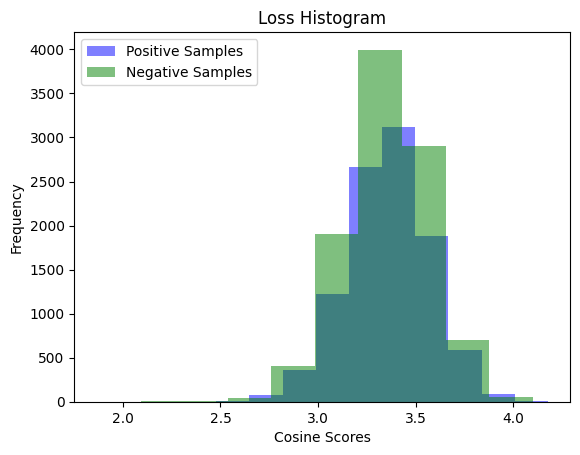

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(3, 1, 1000)

# Plot histograms
plt.hist(pos_losses, bins=10, alpha=0.5, color='blue')
plt.hist(neg_losses, bins=10, alpha=0.5, color='green')

# Add labels and legend
plt.xlabel('Cosine Scores')
plt.ylabel('Frequency')
plt.legend(['Positive Samples', 'Negative Samples'])
plt.title('Loss Histogram')

# Show the plot
plt.show()


In [ ]:
`import numpy as np
import matplotlib.pyplot as plt

# Generate random data
#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(3, 1, 1000)

# Plot histograms
plt.hist(pos_losses, bins=10, alpha=0.5, color='blue')
plt.hist(neg_losses, bins=10, alpha=0.5, color='green')

# Add labels and legend
plt.xlabel('Cosine Scores')
plt.ylabel('Frequency')
plt.legend(['Positive Samples', 'Negative Samples'])
plt.title('Loss Histogram')

# Show the plot
plt.show()


# Speaker level

In [ ]:
class MIAttack_test:
  def __init__(self, target_model, classifier, batch_size = 1): 
    self.target_model = target_model
    self.shadow_model = shadow_model
    self.classifier = classifier
    self.loss_func= AdditiveAngularMargin()
    self.dropper = DropFreq()
    self.dropper2 = DropChunk(drop_start=500, drop_end=900, noise_factor=0.)
    self.noisifier = AddNoise('/content/speechbrain/tests/samples/annotation/noise.csv',
                    replacements={'noise_folder': '/content/speechbrain/tests/samples/noise'})
    self.perturbator = SpeedPerturb(orig_freq=16000, speeds=[70])
    self.clipper = DoClip(clip_low=0.001, clip_high=0.01)
    self.babbler = AddBabble(snr_low=0, snr_high=10)
    self.batch = batch_size


  def get_augment1(self, signal, freq = 16000):
    #dropper = DropFreq()
    signal = self.dropper(signal)
    return signal
  
  def get_augment2(self, signal, freq = 16000):
    length = torch.ones(self.batch)
    signal = self.dropper2(signal, length)
    return signal

  def get_augment3(self, signal, freq = 16000):
    signal = self.noisifier(signal, torch.ones(self.batch))
    return signal

  def get_augment4(self, signal, freq = 16000):
    signal = self.perturbator(signal)
    return signal

  def get_augment5(self, signal, freq = 16000):
    signal = self.clipper(signal)
    return signal

  def get_augment6(self, signal, freq = 16000):
    length = torch.ones(self.batch)
    signal = self.babbler(signal, length)

  def get_augment(self, signal, freq):
    #aug = SpecAugment()
    #a = torch.rand([1, 80])
    #signal = torch.squeeze(self.spec_aug(torch.unsqueeze(signal, dim = 0)))
    #print(a.shape)

    '''#print('ewr-----', signal.shape)
    aug = SpecAugment()
    corrupter = EnvCorrupt(babble_speaker_count=50)
    #print('wfrwef',signal)
    signal = torch.squeeze(aug(torch.unsqueeze(signal, dim = 0)))
    print('------',signal)
    signal = corrupter(signal, torch.ones(signal.shape[0]))
    '''
    mod_signals = [self.get_augment1(signal, freq), self.get_augment2(signal, freq), self.get_augment3(signal, freq), self.get_augment4(signal, freq), self.get_augment5(signal, freq)]
    #clean = signal.unsqueeze(0)
    #perturbator = SpeedPerturb(orig_freq=16000, speeds=[90])
    #changed = perturbator(clean, torch.ones(1))
    return mod_signals

  def get_cos_sim(self, signal, freq=16000):
    orig_signal = torch.cat(signal)
    #output_probs1, score, index, text_lab = self.shadow_model.classify_batch(orig_signal)
    embeddings1 = self.shadow_model.encode_batch(orig_signal)
    aug_signals = self.get_augment(orig_signal, freq)
    scores = torch.empty((self.batch, 1), device = "cuda")

    for aug_signal in aug_signals:
      #output_probs2, score2, index2, text_lab2 = self.shadow_model.classify_batch(aug_signal)
      embeddings2 = self.shadow_model.encode_batch(aug_signal)
      scores = torch.cat((scores, torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim = 2)), dim = 1)
    #print(scores.shape)
      #scores.append(distance.cosine(embeddings1.cpu(), embeddings2.cpu()))
    #print('ececfwc', distance.cosine(orig_signal.cpu(), aug_signal.cpu()))
    #cosine_sim=self.cos(embeddings1, embeddings2).cpu() 
    #print(embeddings1.shape, embeddings2.shape)
    return scores[:,1:]

  def query(self, signal, label = None):  #input: signal, fs = torchaudio.load("tests/samples/single-mic/example1.wav")
    score = self.get_cos_sim(signal)
    #print(score.shape)
    return score

  def get_queried_res(self, data_csv): #input - .wav files
    data_files = data_csv['wav']
    start_frame = data_csv['start']
    end_frame = data_csv['stop']
    labels = data_csv['present_label']
    #print(data_files)
    self.labels = []
    

    scores = []
    #losses = []
  
    for i in tqdm(range(0,len(data_files),4)):
      signals = []
      for j in range(self.batch):
          f = data_files[i+j]
          f = '/content/wav_files/wav/'+f
          #if True:
          signal, _ = torchaudio.load(f)
          #print(signal.shape)
          signal = signal[:, int(start_frame[i]) : int(end_frame[i])]
          signals.append(signal)
          #signal = signal[:,start_frame:end_frame]
      score = self.query(signals, labels[i:i+self.batch])
      #scores = scores + (torch.squeeze(score).tolist())
      #losses.append([0])
      scores = scores + (torch.sum(score, dim = 1)).cpu().tolist() # TODO: Add mean and std instead of sum
      #losses.append([0])
      self.labels+=(list(labels[i:i+self.batch]))

    #print(scores)
    self.scores = scores
    #print(self.scores)
    #self.losses = losses
    #self.queries = np.array(self.queries)
    #self.labels = np.array(self.labels)
    return self.scores, self.labels

  def test_classifier(self, data, criteria='confidence'):
    scores, labels = self.get_queried_res(data)
    scores= [[score] for score in scores]

    res = self.classifier.predict(scores)

    #score = classifier.score(queries, labels)
    score = classification_report(res, labels)
    return res, score

In [ ]:
class MIAttack_train:
  def __init__(self, target_model, shadow_model, classifier, batch_size = 1): 
    self.target_model = target_model
    self.shadow_model = shadow_model
    self.classifier = classifier
    self.loss_func= AdditiveAngularMargin()
    self.spec_aug = SpecAugment()
    self.cos = torch.nn.CosineSimilarity(dim=0)
    self.dropper = DropFreq()
    self.dropper2 = DropChunk(drop_start=500, drop_end=900, noise_factor=0.)
    self.noisifier = AddNoise('/content/speechbrain/tests/samples/annotation/noise.csv',
                    replacements={'noise_folder': '/content/speechbrain/tests/samples/noise'})
    self.perturbator = SpeedPerturb(orig_freq=16000, speeds=[70])
    self.clipper = DoClip(clip_low=0.001, clip_high=0.01)
    self.babbler = AddBabble(snr_low=0, snr_high=10)
    self.batch = batch_size


  def get_augment1(self, signal, freq = 16000): #Drop Frequency
    signal = self.dropper(signal)
    return signal
  
  def get_augment2(self, signal, freq = 16000): #Drop Chunk 
    length = torch.ones(self.batch)
    signal = self.dropper2(signal, length)
    return signal

  def get_augment3(self, signal, freq = 16000): #Add noise
    signal = self.noisifier(signal, torch.ones(self.batch)) 
    return signal

  def get_augment4(self, signal, freq = 16000): #Speed Pert
    signal = self.perturbator(signal)
    return signal

  def get_augment5(self, signal, freq = 16000): #Clip audio
    signal = self.clipper(signal)
    return signal

  def get_augment6(self, signal, freq = 16000): #Add babble
    length = torch.ones(self.batch)
    signal = self.babbler(signal, length)

  def get_augment(self, signal, freq):
    mod_signals = [self.get_augment1(signal, freq), self.get_augment2(signal, freq), self.get_augment3(signal, freq), self.get_augment4(signal, freq), self.get_augment5(signal, freq)]
    return mod_signals

  def get_cos_sim(self, signal, freq=16000):
    orig_signal = torch.cat(signal)
    #output_probs1, score, index, text_lab = self.shadow_model.classify_batch(orig_signal)
    embeddings1 = self.shadow_model.encode_batch(orig_signal)
    aug_signals = self.get_augment(orig_signal, freq)
    scores = torch.empty((self.batch, 1), device = "cuda")

    for aug_signal in aug_signals:
      #output_probs2, score2, index2, text_lab2 = self.shadow_model.classify_batch(aug_signal)
      embeddings2 = self.shadow_model.encode_batch(aug_signal)
      scores = torch.cat((scores, torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim = 2)), dim = 1)
    return scores[:,1:]

  def query(self, signal, label = None):  #input: signal, fs = torchaudio.load("tests/samples/single-mic/example1.wav")
    score = self.get_cos_sim(signal)
    #print(score.shape)
    return score

  def get_queried_res(self, data_csv): #input - .wav files
    data_files = data_csv['wav']
    start_frame = data_csv['start']
    end_frame = data_csv['stop']
    labels = data_csv['present_label']
    #print(data_files)
    self.labels = []
    

    scores = []
    #losses = []

    for i in tqdm(range(0,len(data_files),self.batch)):
      signals = []
      for j in range(self.batch):
          f = data_files[i+j]
          f = '/content/wav_files/wav/'+f
          #if True:
          signal, _ = torchaudio.load(f)
          #print(signal.shape)
          #print(int(start_frame[i]),int(end_frame[i]))
          signal = signal[:, int(start_frame[i]) : int(end_frame[i])]
          signals.append(signal)
          #signal = signal[:,start_frame:end_frame]
      score = self.query(signals, labels[i:i+self.batch])
      #print('---',score.shape)
      #scores = scores + (torch.squeeze(score).tolist())
      #print(score.shape)
      #print(torch.squeeze(torch.sum(score, dim = 1)).shape)
      scores = scores + (torch.sum(score, dim = 1)).cpu().tolist()
      #losses.append([0])
      self.labels+=(list(labels[i:i+self.batch]))

    #print(scores)
    self.scores = scores
    #print(self.scores)
    #self.losses = losses
    #self.queries = np.array(self.queries)
    #self.labels = np.array(self.labels)
    return self.scores, self.labels

  def train_classifier(self, data, criteria = 'confidence'):
    scores, labels = self.get_queried_res(data)
    scores= [[score] for score in scores]
    print((scores))
    print((labels))

    self.clf = self.classifier.fit(scores, labels )
    return self.clf


In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size= int(percentages[2] *len(train_df)))
len(chosen_idx)
df1 = train_df.iloc[chosen_idx]
batch_size = 1
clf = LogisticRegression(random_state=0, max_iter=500) 
mi_train = MIAttack_train(target_model, shadow_model, clf)
trained_classifier = mi_train.train_classifier(df1.reset_index())
mi_test = MIAttack_test(target_model, trained_classifier, batch_size)
res, score = mi_test.test_classifier(test_df)

100%|██████████| 16000/16000 [29:42<00:00,  8.97it/s]


[[3.283939838409424], [3.4833860397338867], [3.5865325927734375], [3.2349181175231934], [3.4263248443603516], [3.275712013244629], [3.2135818004608154], [3.383665084838867], [3.426830768585205], [3.338188886642456], [3.246950387954712], [3.0979361534118652], [3.4953346252441406], [3.6670804023742676], [3.501047134399414], [3.309831142425537], [3.3696513175964355], [3.401674270629883], [3.4021494388580322], [3.7337288856506348], [3.1827006340026855], [3.4939799308776855], [3.31542706489563], [3.460818290710449], [3.4195971488952637], [3.3030779361724854], [3.608707904815674], [3.5587892532348633], [3.6401989459991455], [3.3594822883605957], [3.113175868988037], [3.3022141456604004], [3.734915256500244], [3.364428758621216], [3.2909631729125977], [3.365306854248047], [3.312117338180542], [3.371854782104492], [3.420163631439209], [3.402042865753174], [3.342540740966797], [2.866605520248413], [3.2194485664367676], [3.677644968032837], [3.5542044639587402], [3.1860456466674805], [3.14816021

100%|██████████| 500/500 [00:56<00:00,  8.79it/s]


AttributeError: ignored

In [ ]:
s = [[sc] for sc in mi_train.scores]
res = trained_classifier.predict(s)

In [ ]:
print(classification_report(res, mi_train.labels))

              precision    recall  f1-score   support

         0.0       0.51      0.52      0.52      7817
         1.0       0.53      0.52      0.53      8183

    accuracy                           0.52     16000
   macro avg       0.52      0.52      0.52     16000
weighted avg       0.52      0.52      0.52     16000



In [ ]:
train_df[train_df['present_label']==0]

,wav,start,stop,spk_id,present_label


In [ ]:
train_df2

,Unnamed: 0,ID,duration,wav,start,stop,spk_id,present_label
0,467062,id11083--KMGLj7Ql3ZY--00001_0_300,10.600062,/localscratch/voxceleb1/wav/id11083/KMGLj7Ql3Z...,0,48000,id11083,True
1,1348641,id10780--9tFeMr459a8--00004_0_300,4.200062,/localscratch/voxceleb1/wav/id10780/9tFeMr459a...,0,48000,id10780,True
2,255984,id10744--SY8uvIAIT4E--00003_0_300,7.000063,/localscratch/voxceleb1/wav/id10744/SY8uvIAIT4...,0,48000,id10744,False
3,16199,id10004--lu_eVSfv3Tg--00036_0_300,4.320062,/localscratch/voxceleb1/wav/id10004/lu_eVSfv3T...,0,48000,id10004,False
4,2065412,id10355--yI3OyR7_oJ4--00022_0_300,7.400062,/localscratch/voxceleb1/wav/id10355/yI3OyR7_oJ...,0,48000,id10355,True
...,...,...,...,...,...,...,...,...
19995,1556787,id11006--PpUmNsKnClc--00009_0_300,6.960063,/localscratch/voxceleb1/wav/id11006/PpUmNsKnCl...,0,48000,id11006,True
19996,1895790,id10117--2qiHu6rrGvI--00001_0_300,12.080063,/localscratch/voxceleb1/wav/id10117/2qiHu6rrGv...,0,48000,id10117,True
19997,187487,id10963--JRXqAuc9yZk--00007_0_300,6.120063,/localscratch/voxceleb1/wav/id10963/JRXqAuc9yZ...,0,48000,id10963,False
19998,31864,id10057--ncUmMIRWFts--00008_0_300,7.600062,/localscratch/voxceleb1/wav/id10057/ncUmMIRWFt...,0,48000,id10057,False
